In [13]:
import pandas as pd
import numpy as np
from matplotlib import pyplot 
import sqlite3
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics



In [4]:
connect = sqlite3.connect('/Users/koppakapremsai/Downloads/testClaims_hu.db')
df = pd.read_sql('select * from highUtilizationPredictionV2wco', connect)
#creating dummies for attribute race
race = pd.get_dummies(df['race'], dummy_na=False)
df=pd.concat([df,race], axis=1)
# split into training and testing
tr, ts = train_test_split(df, test_size=0.2)
# create list of input attributes
cols = list(df.columns)
cols.remove('index')
cols.remove('race')
cols.remove('patient_id')
cols.remove('claimCount')
cols.remove('HighUtilizationY2')

In [6]:
logr = LogisticRegression(solver='lbfgs', C=0.9, max_iter=1000)
logr.fit(tr[cols], tr['HighUtilizationY2'])

LogisticRegression(C=0.9, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [7]:
randfo = RandomForestClassifier(n_estimators=100, n_jobs=-1)
randfo.fit(tr[cols], tr['HighUtilizationY2'])

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

In [8]:
probs_lr_tr = logr.predict_proba(tr[cols])[:,1]
probs_lr_ts = logr.predict_proba(ts[cols])[:,1]
probs_rf_tr = randfo.predict_proba(tr[cols])[:,1]
probs_rf_ts = randfo.predict_proba(ts[cols])[:,1]

In [9]:
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
calcur = calibration_curve(ts['HighUtilizationY2'],probs_rf_ts, n_bins=10)


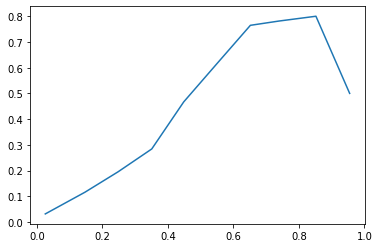

In [17]:
pyplot.plot(calcur[1],calcur[0])

(array([1.7275e+04, 3.0820e+03, 1.2850e+03, 4.4400e+02, 2.5800e+02,
        1.3700e+02, 8.5000e+01, 3.2000e+01, 4.0000e+00, 3.0000e+00]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 1 Patch objects>)

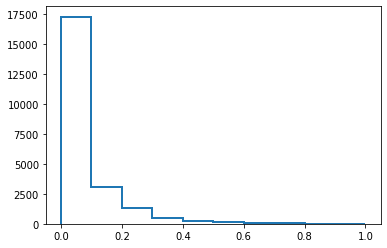

In [18]:
pyplot.hist(probs_rf_ts, range=(0, 1), bins=10, histtype="step", lw=2)

In [20]:
rf_iso = CalibratedClassifierCV(randfo, cv=5, method='isotonic')

In [22]:
rf_sig = CalibratedClassifierCV(randfo, cv=5, method='sigmoid')
rf_iso.fit(tr[cols], tr['HighUtilizationY2'])

CalibratedClassifierCV(base_estimator=RandomForestClassifier(bootstrap=True,
                                                             class_weight=None,
                                                             criterion='gini',
                                                             max_depth=None,
                                                             max_features='auto',
                                                             max_leaf_nodes=None,
                                                             min_impurity_decrease=0.0,
                                                             min_impurity_split=None,
                                                             min_samples_leaf=1,
                                                             min_samples_split=2,
                                                             min_weight_fraction_leaf=0.0,
                                                             n_estimators=100,
                

In [23]:
rf_sig.fit(tr[cols], tr['HighUtilizationY2'])

CalibratedClassifierCV(base_estimator=RandomForestClassifier(bootstrap=True,
                                                             class_weight=None,
                                                             criterion='gini',
                                                             max_depth=None,
                                                             max_features='auto',
                                                             max_leaf_nodes=None,
                                                             min_impurity_decrease=0.0,
                                                             min_impurity_split=None,
                                                             min_samples_leaf=1,
                                                             min_samples_split=2,
                                                             min_weight_fraction_leaf=0.0,
                                                             n_estimators=100,
                

In [24]:
probs_rf_tr_iso = rf_iso.predict_proba(tr[cols])[:,1]
probs_rf_ts_iso = rf_iso.predict_proba(ts[cols])[:,1]
probs_rf_tr_sig = rf_sig.predict_proba(tr[cols])[:,1]
probs_rf_ts_sig = rf_sig.predict_proba(ts[cols])[:,1]

In [25]:
cur_rf_tr_iso = calibration_curve(tr['HighUtilizationY2'],probs_rf_tr_iso, n_bins=10)
cur_rf_ts_iso = calibration_curve(ts['HighUtilizationY2'],probs_rf_ts_iso, n_bins=10)
cur_rf_tr_sig = calibration_curve(tr['HighUtilizationY2'],probs_rf_tr_sig, n_bins=10)
cur_rf_ts_sig = calibration_curve(ts['HighUtilizationY2'],probs_rf_ts_sig, n_bins=10)

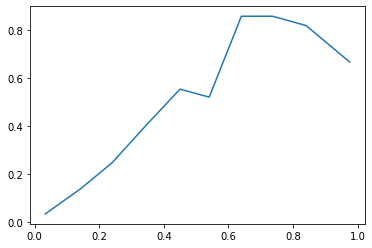

In [26]:
pyplot.plot(cur_rf_ts_iso[1],cur_rf_ts_iso[0])




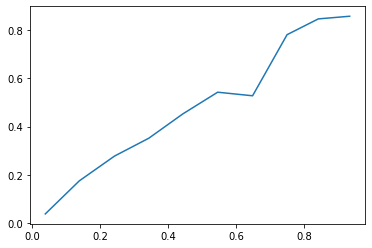

In [27]:
pyplot.plot(cur_rf_ts_sig[1],cur_rf_ts_sig[0])




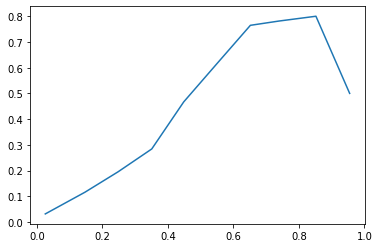

In [30]:

pyplot.plot(calcur[1],calcur[0])



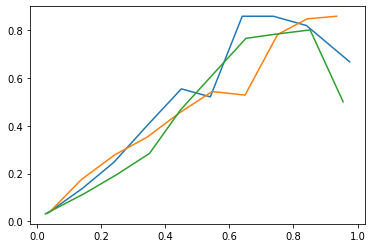

In [32]:
plt.plot(cur_rf_ts_iso[1],cur_rf_ts_iso[0])
plt.plot(cur_rf_ts_sig[1],cur_rf_ts_sig[0])
plt.plot(calcur[1],calcur[0])



In [33]:
#Experiment with claims close to 100 claims high utilization boundary.

In [37]:
from sklearn.metrics import auc
from sklearn.metrics import roc_curve
from sklearn.metrics import accuracy_score

lr = LogisticRegression(solver='lbfgs', C=0.9, max_iter=1000)
lr.fit(tr[cols],tr['HighUtilizationY2'])
probs = lr.predict_proba(ts[cols])[:,1]
fpr,tpr,thresholds = roc_curve(ts['HighUtilizationY2'],probs)
auc(fpr,tpr)
accuracys = []
for cnt in range(0,300,10):
    tt = ts[(ts['claimCount'] >= cnt) & (ts['claimCount'] < cnt + 10)]
    probs = lr.predict(tt[cols])
    acc = accuracy_score(probs,tt['HighUtilizationY2'])
    print(acc)
    accuracys.append(acc)

0.9957402865625403
0.9989798520785514
0.9979473144030107
0.9969924812030075
0.9945167923235092
0.9932692307692308
0.9859550561797753
0.9855072463768116
0.9840546697038725
0.9527272727272728
0.14925373134328357
0.034482758620689655
0.030303030303030304
0.06015037593984962
0.07894736842105263
0.05263157894736842
0.058823529411764705
0.18032786885245902
0.07547169811320754
0.0784313725490196
0.06818181818181818
0.15384615384615385
0.2
0.03571428571428571
0.25
0.05263157894736842
0.16666666666666666
0.25
0.11764705882352941
0.25


<BarContainer object of 30 artists>

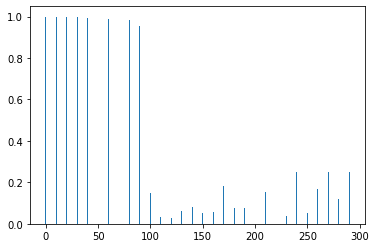

In [39]:
#plotting accuracies
pyplot.bar(range(0,300,10),accuracys)

In [40]:
rf = RandomForestClassifier(n_estimators=100, n_jobs=-1)  
rf.fit(tr[cols],tr['HighUtilizationY2'])  
probs = rf.predict_proba(ts[cols])[:,1]  
fpr,tpr,thresholds = roc_curve(ts['HighUtilizationY2'],probs)  
auc(fpr,tpr)
accuracy = [] 
for cnt in range(0,300,10): 
    tt = ts[(ts['claimCount'] >= cnt) & (ts['claimCount'] < cnt + 10)] 
    probs = rf.predict(tt[cols]) 
    acc = accuracy_score(probs,tt['HighUtilizationY2']) 
    print(acc) 
    accuracy.append(acc)

0.9972892732670712
0.9979597041571028
0.9993157714676703
0.9949874686716792
0.9972583961617546
0.9961538461538462
0.9901685393258427
0.9818840579710145
0.979498861047836
0.9818181818181818
0.14925373134328357
0.024630541871921183
0.03636363636363636
0.045112781954887216
0.07894736842105263
0.07894736842105263
0.1323529411764706
0.19672131147540983
0.11320754716981132
0.13725490196078433
0.09090909090909091
0.15384615384615385
0.28
0.10714285714285714
0.16666666666666666
0.21052631578947367
0.2916666666666667
0.3125
0.29411764705882354
0.5


<BarContainer object of 30 artists>

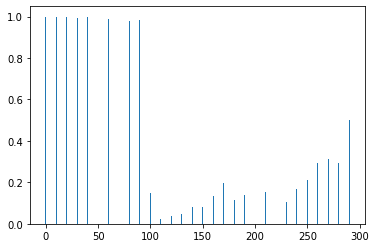

In [41]:
pyplot.bar(range(0,300,10), accuracy)

In [42]:
dat = []
for a in range(65, 91):
    for i in range(100):
        age = a

        # randomly select ELIX codes
        ELIX = [np.random.randint(2) for i in range(29)]

        # randomly select procedures
        G = [np.random.randint(2) for i in range(22)]

        # randomly select drug counts
        drugs = [np.random.randint(13) for i in range(12)] 

        # zero all races
        A = 0
        AmN = 0
        B = 0
        H = 0
        O = 0
        U = 0
        W = 0
        # and randomly select race
        r = np.random.randint(7)
        if r == 0:
            A = 1
        if r == 1:
            AmN = 1
        if r == 2:
            B = 1
        if r == 3:
            H = 1
        if r == 4:
            O = 1
        if r == 5:
            U = 1
        if r == 6:
            W = 1    
        d = [age] + ELIX + G + drugs + [A, AmN, B, H, O, U, W]
        dat.append(d)

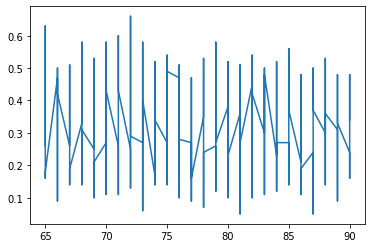

In [43]:
Y = rf.predict_proba(dat)[:,1]
X = np.array(dat)[:,0]
plt.plot(X,Y)

In [44]:
#2. Conduct sensitivity analysis for the testClaims data for predicting high utilization.

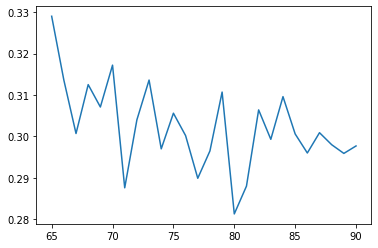

In [46]:
da = pd.DataFrame(X, columns=['age'])
da['prob'] = Y
Ya = da.groupby('age').mean()
Xa = range(65,91)
plt.plot(Xa,Ya)

In [47]:
lr_res = [] 
rf_res = [] 
lr_races=[]
rf_races=[]

for i in range(100): 
    ELIX =[np.random.randint(2) for i in range(29)] 
    G =[np.random.randint(2) for i in range(22)] 
    drugs =[np.random.randint(30) for i in range(12)] 
    age = 65+np.random.randint(30)
    A = 1 
    AmN = 0 
    B = 0 
    H = 0 
    O = 0 
    U = 0 
    W = 0          
    d = [age] + ELIX + G + drugs + [A, AmN, B, H, O, U, W] 
    dat = [d] 
    lr_res.append(lr.predict_proba(dat)[:,1][0]) 
    rf_res.append(rf.predict_proba(dat)[:,1][0]) 
    lr_races.append(sum(lr_res)/len(lr_res)) 
    rf_races.append(sum(rf_res)/len(rf_res)) 

In [48]:

# Generating random data for race  AmN 
lr_res = [] 
rf_res = [] 
lr_races=[]
rf_races=[]
for i in range(100):  
    ELIX = [np.random.randint(2) for i in range(29)] 
    G = [np.random.randint(2) for i in range(22)] 
    drugs = [np.random.randint(30) for i in range(12)] 
    age = 65+np.random.randint(30)
    A = 0 
    AmN = 1 
    B = 0 
    H = 0 
    O = 0 
    U = 0 
    W = 0      
    d = [age] + ELIX + G + drugs + [A, AmN, B, H, O, U, W] 
    dat = [d] 
    lr_res.append(lr.predict_proba(dat)[:,1][0]) 
    rf_res.append(rf.predict_proba(dat)[:,1][0]) 
lr_races.append(sum(lr_res)/len(lr_res)) 
rf_races.append(sum(rf_res)/len(rf_res)) 
# Generate random data for race  B 
lr_res = [] 
rf_res = [] 
lr_races=[]
rf_races=[]
for i in range(100):  
    ELIX = [np.random.randint(2) for i in range(29)] 
    G = [np.random.randint(2) for i in range(22)] 
    drugs = [np.random.randint(30) for i in range(12)] 
    age = 65+np.random.randint(30)
    A = 0 
    AmN = 0 
    B = 1 
    H = 0 
    O = 0 
    U = 0 
    W = 0      
    d = [age] + ELIX + G + drugs + [A, AmN, B, H, O, U, W] 
    dat = [d] 
    lr_res.append(lr.predict_proba(dat)[:,1][0]) 
    rf_res.append(rf.predict_proba(dat)[:,1][0]) 
lr_races.append(sum(lr_res)/len(lr_res)) 
rf_races.append(sum(rf_res)/len(rf_res)) 

In [49]:
# Generating random data for race h
lr_res = [] 
rf_res = [] 
lr_races=[]
rf_races=[]
for i in range(100):  
    ELIX = [np.random.randint(2) for i in range(29)] 
    G = [np.random.randint(2) for i in range(22)] 
    drugs = [np.random.randint(30) for i in range(12)] 
    age = 65+np.random.randint(30)
    A = 0 
    AmN = 0 
    B = 0
    H = 1 
    O = 0 
    U = 0 
    W = 0      
    d = [age] + ELIX + G + drugs + [A, AmN, B, H, O, U, W] 
    dat = [d] 
    lr_res.append(lr.predict_proba(dat)[:,1][0]) 
    rf_res.append(rf.predict_proba(dat)[:,1][0]) 
lr_races.append(sum(lr_res)/len(lr_res)) 
rf_races.append(sum(rf_res)/len(rf_res)) 
# generate random data for race  O
lr_res = [] 
rf_res = [] 
lr_races=[]
rf_races=[]
for i in range(100):  
    ELIX = [np.random.randint(2) for i in range(29)] 
    G = [np.random.randint(2) for i in range(22)] 
    drugs = [np.random.randint(30) for i in range(12)] 
    age = 65+np.random.randint(30)
    A = 0 
    AmN = 0 
    B = 0
    H = 0 
    O = 1 
    U = 0 
    W = 0      
    d = [age] + ELIX + G + drugs + [A, AmN, B, H, O, U, W] 
    dat = [d] 
    lr_res.append(lr.predict_proba(dat)[:,1][0]) 
    rf_res.append(rf.predict_proba(dat)[:,1][0]) 
lr_races.append(sum(lr_res)/len(lr_res)) 
rf_races.append(sum(rf_res)/len(rf_res)) 
# generate random data for race = U
lr_res = [] 
rf_res = [] 
lr_races=[]
rf_races=[]
for i in range(100):  
    ELIX = [np.random.randint(2) for i in range(29)] 
    G = [np.random.randint(2) for i in range(22)] 
    drugs = [np.random.randint(30) for i in range(12)] 
    age = 65+np.random.randint(30)
    A = 0 
    AmN = 0 
    B = 0 
    H = 0 
    O = 0 
    U = 1
    W = 0      
    d = [age] + ELIX + G + drugs + [A, AmN, B, H, O, U, W] 
    dat = [d] 
    lr_res.append(lr.predict_proba(dat)[:,1][0]) 
    rf_res.append(rf.predict_proba(dat)[:,1][0]) 
lr_races.append(sum(lr_res)/len(lr_res)) 
rf_races.append(sum(rf_res)/len(rf_res)) 

In [50]:
# Generating random data for race W
lr_res = [] 
rf_res = [] 
lr_races=[]
rf_races=[]
for i in range(100):  
    ELIX = [np.random.randint(2) for i in range(29)] 
    G = [np.random.randint(2) for i in range(22)] 
    drugs = [np.random.randint(30) for i in range(12)] 
    age = 65+np.random.randint(30)
    A = 0 
    AmN = 0 
    B = 0 
    H = 0 
    O = 0 
    U = 0
    W = 1      
    d = [age] + ELIX + G + drugs + [A, AmN, B, H, O, U, W] 
    dat = [d] 
    lr_res.append(lr.predict_proba(dat)[:,1][0]) 
    rf_res.append(rf.predict_proba(dat)[:,1][0]) 
lr_races.append(sum(lr_res)/len(lr_res)) 
rf_races.append(sum(rf_res)/len(rf_res)) 

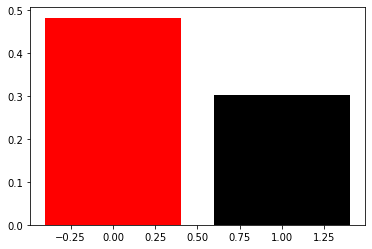

In [52]:
pyplot.bar(range(0,len(lr_races)*2,2), lr_races, color='red') 
pyplot.bar(range(1,len(rf_races)*2,2), rf_races, color='black') 
pyplot.show()

In [53]:
#3. Select randomly two patients from testmcalims test set. 
#Conduct local sensitivity analysis for the prediction on these patients.

In [54]:
p = rf.predict_proba(ts[cols])
p[p[:,1] > 0.7]

array([[0.19      , 0.81      ],
       [0.29      , 0.71      ],
       [0.28      , 0.72      ],
       [0.28      , 0.72      ],
       [0.23      , 0.77      ],
       [0.28      , 0.72      ],
       [0.24      , 0.76      ],
       [0.12      , 0.88      ],
       [0.27733333, 0.72266667],
       [0.18      , 0.82      ],
       [0.05      , 0.95      ],
       [0.27      , 0.73      ],
       [0.24      , 0.76      ],
       [0.25      , 0.75      ],
       [0.04      , 0.96      ],
       [0.19      , 0.81      ],
       [0.29      , 0.71      ],
       [0.24      , 0.76      ],
       [0.27      , 0.73      ],
       [0.29      , 0.71      ],
       [0.29      , 0.71      ],
       [0.25      , 0.75      ],
       [0.26      , 0.74      ],
       [0.2       , 0.8       ],
       [0.25      , 0.75      ],
       [0.23      , 0.77      ],
       [0.1       , 0.9       ],
       [0.28      , 0.72      ],
       [0.22      , 0.78      ],
       [0.18      , 0.82      ],
       [0.

In [55]:
np.where(p[:,1] > 0.7)

(array([  172,   575,   693,  1524,  1568,  1803,  2814,  3650,  3811,
         3877,  5062,  6574,  8267,  9132, 10233, 10600, 10921, 11617,
        11816, 11881, 12166, 13637, 14518, 14909, 15239, 16811, 17982,
        18688, 18958, 19515, 19529, 19633, 19910, 20137, 21414]),)

In [57]:
p1 = rf.predict_proba(ts[cols])
np.where(p1[:,1] <0.4)

(array([    0,     1,     2, ..., 22602, 22603, 22604]),)

In [58]:
test_case = ts.iloc[100]
test_case1 = ts.iloc[201]

In [60]:
binary_cols = {} 
numeric_cols = {} 
for c in cols: 
    cnt = len(tr[c].value_counts().index) 
    mnv = tr[c].min() 
    mxv = tr[c].max() 
    if cnt > 2: 
        avg = tr[c].mean() 
        std = tr[c].std() 
             #print(c, cnt, mnv, mxv, avg, std) 
        numeric_cols[c] = (cnt, mnv, mxv, avg, std) 
    elif cnt == 2: 
        binary_cols[c] = (cnt, mnv, mxv)

In [61]:
def combinations(test_case, binary_cols, numeric_cols):
    dat = pd.DataFrame()
    #Work on binary variables
    for v in binary_cols:
        #print(binary_cols[v])
        # assume that if min is 0 and value in test case is 0, the eature is not present, so fe flit to the other value
        #print( binary_cols[v][1], test_case[v] )
        if (test_case[v] == binary_cols[v][1]): # at the lower value
            #print(v)
            newcase = test_case.copy()
            newcase[v] = binary_cols[v][2]
            newcase['changed_var'] = v
            newcase['dir'] = '+'
            newcase['type'] = 'b'
            #print(newcase)
            dat=dat.append(newcase)
        else:
            #print(v)
            newcase = test_case.copy()
            newcase[v] = binary_cols[v][1]
            newcase['changed_var'] = v
            newcase['dir'] = '-'
            newcase['type'] = 'b'
            #print(newcase)
            dat=dat.append(newcase)   


    # now work on numeric variables
    for v in numeric_cols:
        # assume that we do not change values which are at their lowest value
        
            print(v)
            # val + sd
            newcase = test_case.copy()
            newcase[v] = min(newcase[v] + numeric_cols[v][4], numeric_cols[v][2] )
            newcase['changed_var'] = v
            newcase['dir'] = '+'
            newcase['type'] = 'n'
            dat=dat.append(newcase)
            # val -sd
            newcase = test_case.copy()
            newcase[v] = max(newcase[v] - numeric_cols[v][4], numeric_cols[v][1] )
            newcase['changed_var'] = v
            newcase['dir'] = '-'
            newcase['type'] = 'n'
            dat=dat.append(newcase)
    return dat

In [62]:
dat = combinations(test_case, binary_cols, numeric_cols)

age
drugs_m0-1
drugs_m1-2
drugs_m2-3
drugs_m3-4
drugs_m4-5
drugs_m5-6
drugs_m6-7
drugs_m7-8
drugs_m8-9
drugs_m9-10
drugs_m10-11
drugs_m11-12


In [69]:
def predict_combinations(dat, clf, pr): 
    probs = clf.predict_proba(dat[cols]) 
    d = pd.DataFrame(dat[['type','changed_var','dir']]) 
    d['prob'] = probs[:,1] 
    d['change'] = probs[:,1] - pr 
    return d.sort_values('change', ascending=False)

In [71]:
pred = rf.predict_proba([test_case[cols]])[:,1]
predc = predict_combinations(dat, rf, pred)


In [73]:
print("main confirming factors : the numbers indicate probability in the case these factors were not present:")
print(predc[(((predc['type'] =='b') & (predc['dir'] =='-')) | ((predc['type'] =='n') & (predc['dir'] =='-'))) & (predc['change'] < 0)].sort_values('change')[:10])
print("main disconfirming factors:")
print(predc[(((predc['type'] =='b') & (predc['dir'] =='-')) | ((predc['type'] =='n') & (predc['dir'] =='-'))) & (predc['change'] > 0)].sort_values('change')[-10:])



main confirming factors : the numbers indicate probability in the case these factors were not present:
      type changed_var dir  prob  change
20266    b      ELIX13   -  0.00   -0.04
20266    b        G-17   -  0.00   -0.04
20266    b        G-21   -  0.01   -0.03
20266    b        G-13   -  0.02   -0.02
20266    b      ELIX26   -  0.02   -0.02
20266    n         age   -  0.02   -0.02
main disconfirming factors:
      type changed_var dir  prob  change
20266    b         G-6   -  0.05    0.01
20266    b        G-18   -  0.07    0.03


In [74]:
data = combinations(test_case1, binary_cols, numeric_cols)
pred1 = rf.predict_proba([test_case1[cols]])[:,1]
predc1 = predict_combinations(dat, rf, pred1)

age
drugs_m0-1
drugs_m1-2
drugs_m2-3
drugs_m3-4
drugs_m4-5
drugs_m5-6
drugs_m6-7
drugs_m7-8
drugs_m8-9
drugs_m9-10
drugs_m10-11
drugs_m11-12


In [75]:
predc1

,type,changed_var,dir,prob,change
20266,b,ELIX10,+,0.24,0.22
20266,b,ELIX5,+,0.14,0.12
20266,b,ELIX29,+,0.12,0.10
20266,b,ELIX19,+,0.12,0.10
20266,b,ELIX1,+,0.11,0.09
...,...,...,...,...,...
20266,b,ELIX14,+,0.01,-0.01
20266,b,G-21,-,0.01,-0.01
20266,b,G-11,+,0.01,-0.01
20266,b,ELIX13,-,0.00,-0.02


In [76]:
print("main confirming factors : the numbers indicate probability in the case thee factors were not present:")
print(predc1[(((predc1['type'] =='b') & (predc1['dir'] =='-')) | ((predc1['type'] =='n') & (predc1['dir'] =='-'))) & (predc1['change'] < 0)].sort_values('change')[:10])
print("main disconfirming factors:")
print(predc1[(((predc1['type'] =='b') & (predc1['dir'] =='-')) | ((predc1['type'] =='n') & (predc1['dir'] =='-'))) & (predc1['change'] > 0)].sort_values('change')[-10:])

main confirming factors : the numbers indicate probability in the case thee factors were not present:
      type changed_var dir  prob  change
20266    b      ELIX13   -  0.00   -0.02
20266    b        G-17   -  0.00   -0.02
20266    b        G-21   -  0.01   -0.01
main disconfirming factors:
      type   changed_var dir  prob  change
20266    n    drugs_m0-1   -  0.04    0.02
20266    n    drugs_m5-6   -  0.04    0.02
20266    n    drugs_m7-8   -  0.04    0.02
20266    n    drugs_m1-2   -  0.04    0.02
20266    n    drugs_m2-3   -  0.04    0.02
20266    n    drugs_m3-4   -  0.04    0.02
20266    n    drugs_m6-7   -  0.04    0.02
20266    n  drugs_m11-12   -  0.04    0.02
20266    b           G-6   -  0.05    0.03
20266    b          G-18   -  0.07    0.05
